In [57]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import wfdb
import numpy as np
import os
import csv
import heapq
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier  # or KNeighborsRegressor if regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter


In [3]:
def downsample_by_averaging(signal, factor):
    downsampled_signal = []
    
    for i in range(0, len(signal), factor): # moves by index of 8
        chunk = signal[i:i+factor, :] 
        downsampled_signal.append(np.mean(chunk, axis=0))  # avg of each column
        
    return np.array(downsampled_signal)


In [4]:
data_list=[] #takes all the subjects 
directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
csv_path = os.path.join(directory, 'subjectinfo.csv') 
for i in range(1,21):
    ACCTEMPEDA_Path = os.path.join(directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file

    # ACCTEMPEDA_DownSampled = downsample_by_averaging(ACCTEMPEDA_Record.p_signal, 8) # downsample ACCTEMP EDA as it is 8 HZ
    # ACCTEMPEDA_DownSampled_Record = wfdb.Record(
    #     record_name=f'Subject{i}_AccTempEDA_DownSampled', 
    #     p_signal=ACCTEMPEDA_DownSampled, 
    #     fs=1,
    #     sig_name=ACCTEMPEDA_Record.sig_name,
    #     units=ACCTEMPEDA_Record.units        
    # )
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['subject']) == i:
                data_list.append({
                    'subject_id': i,
                    'acc_temp_eda': ACCTEMPEDA_Record,
                    'spo2_hr': SPO2HR_Record,
                    'annotations': annotations,
                    'age': int(row['age']),
                    'gender': row['gender'],
                    'height_cm': int(row['height/cm']),
                    'weight_kg': int(row['weight/kg'])
                })
                #print(f"Subject {i} Metadata:")
                #print(f"  Age: {int(row['age'])}")
                #print(f"  Gender: {row['gender']}")
                #print(f"  Height (cm): {int(row['height/cm'])}")
                #print(f"  Weight (kg): {int(row['weight/kg'])}")
                

In [5]:
sub = data_list[1]
#print()
print(sub['acc_temp_eda'].p_signal)

[[ 0.96997131 -0.67005829 -0.07004547 28.70009461  0.81804387]
 [ 0.96997131 -0.6800177  -0.07004547 28.90009461  0.81804387]
 [ 0.97998291 -0.67005829 -0.07004547 28.90009461  0.81601674]
 ...
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.02999969 -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]]


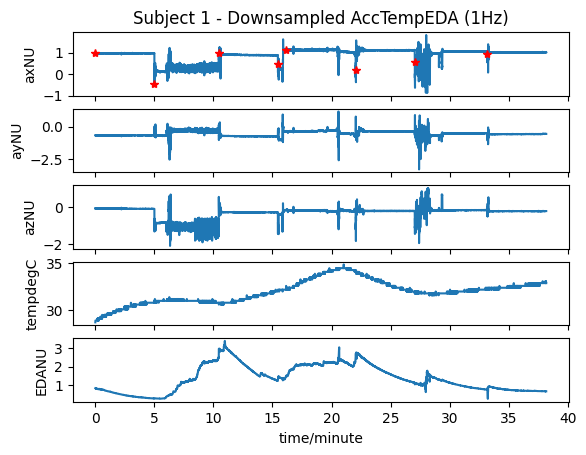

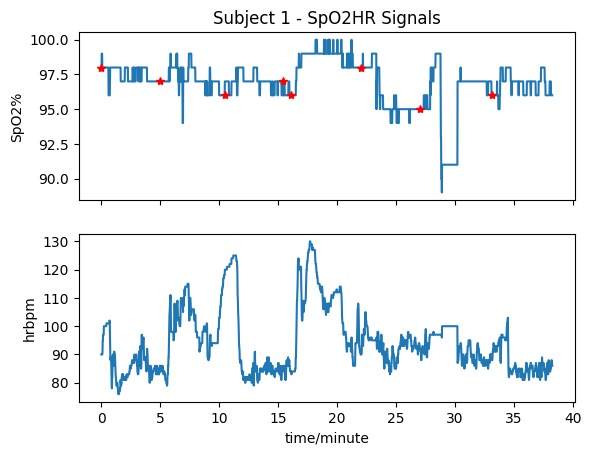

In [6]:
subject = data_list[1]  
wfdb.plot_wfdb( record=subject['acc_temp_eda'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - Downsampled AccTempEDA (1Hz)')
wfdb.plot_wfdb( record=subject['spo2_hr'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - SpO2HR Signals')

# Extracting and Combining Data by Class

## Utility functions

In [7]:
# extract the ranges of each stage from their annotation
def get_stages(annotation, size):
    stages = []
    for i, (samp, note) in enumerate(zip(annotation.sample, annotation.aux_note)):
        stages.append({"Label" : note, "start": samp, "end": 0}) # dummy end
    
    for i in range((len(stages) - 1)):
        stages[i]["end"] = stages[i+1]["start"] # each stages end is the next one's beginning
    stages[-1]["end"] = size # set the end of last stage as the length of the data

    return stages  

In [8]:
# find label of a data point at a given index based on the ranges of each stage
def find_label(stages, index):
    for stage in stages:
        if index >= stage['start'] and index < stage['end']:
            return stage["Label"]
    return "Unknown"

In [9]:
# label the AccTempEDA data
def extract_labeled_AccTempEDA(record, annotation):
    stages = get_stages(annotation, record.p_signal.shape[0]) # get the range for each stage
    data = record.p_signal # extract the data into a numpy array
    labels = [] # array to store the labels corresponding to each data point in the record
    for idx, entry in enumerate(data): # loop over all the data
        labels.append((find_label(stages, idx))) # find the label based on the points index
    labeled_data = np.column_stack((data, labels)) # append the labels column to the data 
    return labeled_data # return the labeled data

In [10]:
# downsample by averaging BUT make sure you stay within a given class
def downsample_by_averaging(data, factor):
    downsampled_data = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, :-1].astype(float) # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            avg_chunk = np.mean(chunk, axis=0)
            downsampled_data.append(np.append(avg_chunk, class_label))  # avg of each column while adding back the label
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
                    
    return np.array(downsampled_data)

In [11]:
# combine AccTempEDA and Spo2HR data while truncating them to be of the same length
# CRUCIAL but naive assumption! time stamps match after downsampling (technically incorrect)
def combine(AccTempEDA, Spo2HR):
    min_length = min(len(AccTempEDA), len(Spo2HR)) # finds the minimum length to align the points properly

    # concatenate the truncated columns from AccTempEDA with those from Spo2HR and add the labels at the end
    combined_data = np.column_stack((AccTempEDA[:min_length, :-1], Spo2HR[:min_length], AccTempEDA[:min_length, -1:]))

    return combined_data

# Extracting Raw and Preprocessed data

In [12]:
# val is 1 incase labels are included 0 otherwise 
def preprocess(wavevec):
    final_vec = [] # stores the filtered signals
    for i in range(0,len(wavevec[0])): # goes through each point in the signal
        one_col = [wavevec[s][i].astype(float) for s in range(0,len(wavevec))] # filters column by column
        one_col = medfilt(one_col, kernel_size=9) # filtering each column
        if i == 0:
            final_vec = one_col
        else:
            final_vec = np.column_stack((final_vec, one_col))
    return final_vec

In [13]:
# get the full data for each subject
def get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [14]:
def get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

# Function to read and get raw data for all subjects and store them in csvs

In [15]:
read_directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
type = "Preprocessed"
write_directory= f"Subject Data {type}"
all_sub_info = []
for i in range(1,21):
    csv_path = os.path.join(write_directory, f'subject_{i}_data_{type}.csv')
    ACCTEMPEDA_Path = os.path.join(read_directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(read_directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file
    subject_data = get_subject_data_preprocessed(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    all_sub_info.append(subject_data)
    # #print(f'subject{i}: {len(subject_data)}') 
    # with open(csv_path, mode='w', newline='') as csvfile:
    #     writer = csv.writer(csvfile)
    #     # Write headers
    #     writer.writerow(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'HR', 'label'])
    #     # Write each row of subject data
    #     for row in subject_data:
    #         writer.writerow(row)

In [16]:
len(all_sub_info)

20

# Function to get the data in the desired window sizes

In [17]:
def windowSel(data, factor):
    # stores the windowed sample
    windowed = []
    labels = []
    # stores the last i in case the window exceeds the size of the sample
    for i in range(0, len(data), factor):
        # checks if i exceeds the sample size
        if i + factor < len(data):
            class_label = data[i][-1] # get the expected class lavel
            if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            # adds the windowed sample 
                windowed.append(data[i: i + factor, :-1])
                labels.append(class_label)
            else:
                continue     
    return windowed, labels

In [18]:
windowed_samps = []
val = 5
for i in range(0,20):
   windowSel(all_sub_info[1],val)
    

# Compute Z score [Normalization] (importnat for methods like KNN, logistic regression, SVM and neural networks

In [20]:
# data includes the features without the labels column
def normalize_data(train_data, test_data):
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)
    return X_train_scaled, X_test_scaled
    
        

# Raw vs Filtered vs Normalized vs Filtered + Normalized

In [21]:
# getting all the data we want

### Will eventually do this for all subjects

In [22]:
i = 2
data_dir = r"non-eeg-dataset-for-assessment-of-neurological-status-1.0.0"

AccTempEDA_record = wfdb.rdrecord(fr"{data_dir}\Subject{i}_AccTempEDA")
Spo2HR_record = wfdb.rdrecord(fr"{data_dir}\Subject{i}_SpO2HR")
AccTempEDA_annotation = wfdb.rdann(fr"{data_dir}\Subject{i}_AccTempEDA", 'atr')
data = get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[:,:-1])


## Least Squares

In [23]:
# note this is for subject 1
raw_data = get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
X, y = raw_data[:, :-1].astype(float), raw_data[:, -1] # splitting 

In [38]:
# cross validation to ensure results are more representative of the average performance

In [24]:
def leastSquares(X, y, norm = False):
    skf = StratifiedKFold(n_splits=5)
    # Prepare lists to store metrics for each fold
    all_preds = []
    all_true = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)
            
        clf = RidgeClassifier(class_weight='balanced') # VERY important because of relax
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Collect predictions and true labels
        all_preds.extend(y_pred)
        all_true.extend(y_test)
    
    # Final combined classification report
    print(classification_report(all_true, all_preds))

### Raw Data

In [25]:
raw_data = get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
X, y = raw_data[:, :-1].astype(float), raw_data[:, -1] # splitting 
leastSquares(X, y)

                 precision    recall  f1-score   support

CognitiveStress       0.60      0.92      0.73       355
EmotionalStress       0.24      0.45      0.32       408
 PhysicalStress       0.87      0.98      0.92       327
          Relax       0.67      0.35      0.46      1200

       accuracy                           0.55      2290
      macro avg       0.60      0.67      0.61      2290
   weighted avg       0.61      0.55      0.54      2290



### Normalized

In [46]:
leastSquares(X, y, True)

                 precision    recall  f1-score   support

CognitiveStress       0.60      0.92      0.73       355
EmotionalStress       0.24      0.45      0.31       408
 PhysicalStress       0.87      0.98      0.92       327
          Relax       0.67      0.35      0.46      1200

       accuracy                           0.54      2290
      macro avg       0.60      0.67      0.60      2290
   weighted avg       0.61      0.54      0.54      2290



### Filtered

In [42]:
# note this is for subject 1
filtered = get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
X, y = filtered[:, :-1].astype(float), filtered[:, -1] # splitting 
leastSquares(X, y)

                 precision    recall  f1-score   support

CognitiveStress       0.60      0.92      0.72       355
EmotionalStress       0.24      0.43      0.31       408
 PhysicalStress       0.87      0.98      0.92       327
          Relax       0.67      0.36      0.47      1200

       accuracy                           0.55      2290
      macro avg       0.59      0.67      0.60      2290
   weighted avg       0.61      0.55      0.54      2290



### Filtered + Normalized

In [47]:
leastSquares(X, y, True)

                 precision    recall  f1-score   support

CognitiveStress       0.60      0.92      0.73       355
EmotionalStress       0.24      0.45      0.31       408
 PhysicalStress       0.87      0.98      0.92       327
          Relax       0.67      0.35      0.46      1200

       accuracy                           0.54      2290
      macro avg       0.60      0.67      0.60      2290
   weighted avg       0.61      0.54      0.54      2290



### KNN

In [33]:
# note this is for subject 1
raw_data = get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
X, y = raw_data[:, :-1].astype(float), raw_data[:, -1] # splitting 

#### Raw Data KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"The optimal K value is: {optimal_k}")


final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

The optimal K value is: 1
Accuracy: 0.9737991266375546
                 precision    recall  f1-score   support

CognitiveStress       0.99      0.97      0.98        75
EmotionalStress       0.96      0.93      0.95        84
 PhysicalStress       0.98      1.00      0.99        55
          Relax       0.97      0.98      0.98       244

       accuracy                           0.97       458
      macro avg       0.98      0.97      0.97       458
   weighted avg       0.97      0.97      0.97       458



#### Filtered+ Preproccesed Norm KNN

In [40]:
filtered = get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
X, y = filtered[:, :-1].astype(float), filtered[:, -1] # splitting 


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"The optimal K value is: {optimal_k}")


final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

The optimal K value is: 1
Accuracy: 0.9978165938864629
                 precision    recall  f1-score   support

CognitiveStress       1.00      1.00      1.00        78
EmotionalStress       0.99      1.00      0.99        70
 PhysicalStress       1.00      1.00      1.00        67
          Relax       1.00      1.00      1.00       243

       accuracy                           1.00       458
      macro avg       1.00      1.00      1.00       458
   weighted avg       1.00      1.00      1.00       458

